## Linear Regression with PCA

In [1]:
## Laading libraries
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
import matplotlib.patches as mpatches
from scipy.optimize import minimize
from pandas_datareader import DataReader
from datetime import datetime
from sklearn.metrics import mean_squared_error
import matplotlib.gridspec as gridspec
import plotly.graph_objects as go
from numpy import array
from numpy import mean
from numpy import cov
from numpy.linalg import eig
%matplotlib inline

## PCA Index Creation

In [2]:
def pcaData(s1, s2, s3, s4, s5, desired_value):
    pca_Data = pd.DataFrame()
    stock1 = DataReader(s1,  'yahoo', datetime(2019,1,1), datetime(2019,12,31));
    stock2 = DataReader(s2,  'yahoo', datetime(2019,1,1), datetime(2019,12,31));
    stock3 = DataReader(s3,  'yahoo', datetime(2019,1,1), datetime(2019,12,31));
    stock4 = DataReader(s4,  'yahoo', datetime(2019,1,1), datetime(2019,12,31));
    stock5 = DataReader(s5,  'yahoo', datetime(2019,1,1), datetime(2019,12,31));
    pca_Data['stock1'] = stock1[desired_value].values
    pca_Data['stock2'] = stock2[desired_value].values
    pca_Data['stock3'] = stock3[desired_value].values
    pca_Data['stock4'] = stock4[desired_value].values
    pca_Data['stock5'] = stock5[desired_value].values
    
    return pca_Data

In [3]:
def pcaIndex(pcaData):
    # define a matrix
    A = array(pcaData)
    # calculate the mean of each column
    M = mean(A.T, axis=1)
    # center columns by subtracting column means
    C = A - M
    # calculate covariance matrix of centered matrix
    V = cov(C.T)
    # eigendecomposition of covariance matrix
    values, vectors = eig(V)
    # project data
    pca_index = vectors.T.dot(C.T)
    
    return pca_index

In [4]:
def pca_var(pca_index):
    record = list()
    var = pca_index.var(axis=1)
    sum_var = var.sum()
    count = 1
    for i in var:
        z = (i/sum_var)*100
        record.append((count, i, z))
        count=count+1
    pca_df = pd.DataFrame(record, columns = ["Variable","Var_Capture","Var_Precentage"])
    return pca_df

## Original Data set

In [5]:
# loading dataset
def getData(strt_date, end_date):
    FF = pd.read_csv("C:\\Users\\sshai\\Desktop\\Northeastern University\\INFO 7374 ML In Finance\\INFO-7374-Machine-Learning-in-Finance\\Dashboard\\Shaishav\\fulldata.csv")
    # Date format change
    FF["Date"] = pd.to_datetime(FF["Date"])
    # Data selection
    df = FF[(FF["Date"] >= strt_date) & (FF["Date"] <= end_date)]
    # Reset Index
    df = df.reset_index()
    df = df.drop(["index"], axis =1)
    # Average Column and no. of days calculations
    df["Average"] = (FF["Open"] + 2*FF["High"] + FF["Close"])/4
    df["Days"] = range(1,df.shape[0]+1)
    df["beta_0"] = 1
    
    return df

In [6]:
def variable_correlation(df):
    fig, ax = plt.subplots(figsize=(20,20))
    sns.heatmap(df.corr(), center=0, cmap="BrBG", annot=True)

## Beta Values Calculations

In [7]:
def beta_values(df, colm):
    x_t = np.array(df[colm])
    y_t = np.array(df[["Open"]])
    b_t = np.matmul(np.matmul(np.linalg.inv(np.matmul(x_t.T,x_t)),x_t.T),y_t)
    b_t = b_t.tolist()
    b_t = [item for sublist in b_t for item in sublist]
    
    return b_t

In [8]:
def beta_coff(beta, df, colm, error):
    df_beta = pd.DataFrame(list(zip(colm, beta)), columns = ["Variables","Beta_Coeff"])
    n = len(df["Open"])
    SE_Coff = list()
    t = list()
    for i in colm:
        SSE = residual_variance(df)
        x_act = df[i]
        n1 = len(df[i])
        x_mean = sum(df[i])/n1
        res = list(x_act - x_mean)
        X = sum(map(lambda i : i * i, res))
        SE = sqrt(SSE/(n-2))/sqrt(X)
        SE_Coff.append(SE)
    df_beta["SE_Coff"] = SE_Coff
    df_beta["T-Value"] = df_beta['Beta_Coeff']/df_beta["SE_Coff"]
    df_beta["P-Value"] = stats.t.sf(abs(df_beta["T-Value"]),n-2)*2
    df_beta["Importance"] = df_beta["P-Value"].apply(lambda x: 'True' if x < 0.05 else 'False')
    df_beta = df_beta.sort_values(by=['Importance'], ascending=False)
    
    return df_beta

## Model, Predictions and Accuracy

In [9]:
def predictions(beta, df, colm):
    x_t = np.array(df[colm])
    b_t = beta
    y_pred = np.matmul(x_t,b_t)
    
    return y_pred

In [10]:
def error_cal(df):
    df["ERROR"] = df["Y_PRED"] - df["Y_ACT"]
    
    return df

In [11]:
def lr(df_train, df_test, colm):
    b_t = beta_values(df_train, colm)
    y_pred_test = predictions(b_t, df_test, colm)
    
    return y_pred_test

In [12]:
def residual_variance(df):
    error = list(df["ERROR"])
    SSE = sum(map(lambda i : i * i, error)) 
    
    return SSE    

In [13]:
def totalError_Square(df):
    y_act = df['Y_ACT']
    n = len(df["Y_ACT"])
    y_mean = sum(df["Y_ACT"])/n
    res = list(y_act - y_mean)
    SST = sum(map(lambda i : i * i, res))
    
    return SST

In [14]:
def R_squared(df):
    error = list(df["ERROR"])
    SSE = residual_variance(df)
    SST = totalError_Square(df)
    r2 = 1 - float(SSE/SST)
    
    return r2 

In [15]:
def rmse_value(df):
    error = list(df["ERROR"])
    SSE = residual_variance(df)
    n = len(error)
    rmse = sqrt(SSE/n)
    
    return rmse

In [16]:
def f_value(df, colm):
    error = list(df["ERROR"])
    k = len(colm) 
    y_act = df['Y_ACT']
    n = len(df["Y_ACT"])
    y_mean = sum(df["Y_ACT"])/n
    y_pred = list(df["Y_PRED"])
    res = [x - y_mean for x in y_pred]
    SSR = sum(map(lambda i : i * i, res))
    SSE = residual_variance(df)
    F = (SSR/k)/(SSE/(n-k-1))
    
    return F

In [17]:
def accuracy(df, colm):
    acc = list()
    pred_df = error_cal(df)
    r_sq = R_squared(df)
    rmse = rmse_value(df)
    f_val = f_value(df,colm)
    acc.append(r_sq)
    acc.append(rmse)
    acc.append(f_val)
    
    return acc

## Visualisation Plot

In [18]:
def create_plot(predictions, labels, title):    
    plot_df = pd.DataFrame({"actual": labels, "predictions": predictions})
    plot_df.plot(figsize=(18, 5), title=title)
    
    return

## BackTesting

In [19]:
def backtesting_df(main_data, pred_data):
    backtesting_df = pd.concat([main_data[["Date","Open","Close","S&P 500-Open","S&P-Close","High"]].reset_index(drop=True),pred_data["Y_PRED"]], axis=1)
    backtesting_df = backtesting_df.rename(columns={"Date": "Date", "Open": "R_Open", "High": "R_High", "Close": "R_Close","S&P 500-Open": "SP_Open","S&P-Close": "SP_Close","Y_PRED": "P_Open"})
    
    return backtesting_df

In [20]:
def back_test(df_backtest):
    df = df_backtest.copy()
    conditions = [(df['P_Open'].shift(-1) > df['R_Open'].shift(-1)) & (df['P_Open'].shift(-1) < df['R_High'].shift(-1)),
                  (df['P_Open'].shift(-1) > df['R_Open'].shift(-1)) & (df['P_Open'].shift(-1) > df['R_High'].shift(-1))]
    choices = [(df['P_Open'].shift(-1) - df['R_Close'])*100/df['R_Close'], 
               (df['R_High'].shift(-1) - df['R_Close'])*100/df['R_Close']]
    #Ra : Portfolio's Return
    df['Ra'] = np.where(df['P_Open'].shift(-1) > df['R_Close'],                          
                              np.select(conditions, choices, default=np.nan),
                              np.nan)
    #Riskfree return (S&P500 return)
    df['Rb'] = np.where(df['P_Open'].shift(-1) > df['R_Close'],                          
                              (df['SP_Open'].shift(-1) - df['SP_Close'])*100/df['SP_Close'],
                              np.nan)
    df = df.dropna()
    #Sharpe ratio
    Sharpe = (df['Ra'] - df['Rb']).mean() / (df['Ra'] - df['Rb']).std()
    beta = ((df[['Ra','Rb']]).cov()).Rb[0] / df['Rb'].var()
    #Treynor ratio
    Treynor  = (df['Ra'] - df['Rb']).mean() / beta    
    #average profit
    profit = df['Ra'].mean()
    #hitrate
    Hitrate = df[df['Ra'] > 0]['Ra'].count() / df['Ra'].count()
    
    return Sharpe, Treynor, profit, Hitrate

## Outputs! Rock and Roll

In [21]:
## User input, can be changed
strt_date = "2019-01-01"
end_date = "2019-12-31"

## final dataset
main_df = getData(strt_date, end_date)
main_df.head()

,Date,High,Low,Open,Close,Volume,Adj Close,Mkt-RF,SMB,HML,...,S&P 500-Open,S&P500-High,S&P-Low,S&P-Close,S&P500-Adj Close,S&P500-Volume,ADS-Index,Average,Days,beta_0
0,2019-01-02,91.389999,89.930000,91.029999,91.279999,9843900.0,88.258690,0.23,0.73,1.15,...,2476.959961,2519.489990,2467.469971,2510.030029,2510.030029,3.733160e+09,0.154689,53.859375,1,1
1,2019-01-03,92.500000,90.379997,90.940002,90.639999,9820200.0,87.639870,-2.45,0.52,1.23,...,2491.919922,2493.139893,2443.959961,2447.889893,2447.889893,3.822860e+09,0.143820,53.531250,2,1
2,2019-01-04,92.489998,90.370003,90.839996,92.489998,10565700.0,89.428635,3.55,0.39,-0.74,...,2474.330078,2538.070068,2474.330078,2531.939941,2531.939941,4.213410e+09,0.132721,52.343750,3,1
3,2019-01-07,92.500000,91.400002,91.910004,92.120003,9012500.0,89.070892,0.94,0.82,-0.67,...,2535.610107,2566.159912,2524.560059,2549.689941,2549.689941,4.104710e+09,0.121334,53.984375,4,1
4,2019-01-08,93.089996,91.820000,92.699997,92.459999,9551300.0,89.399635,1.01,0.44,-0.53,...,2568.110107,2579.820068,2547.560059,2574.409912,2574.409912,4.083030e+09,0.109397,57.507812,5,1


In [22]:
pca_Data = pcaData('JNJ','UL','CL','CHD','PFE','Close')
pca_index = pcaIndex(pca_Data)
pca_df = pca_var(pca_index)

print(pca_df)

   Variable  Var_Capture  Var_Precentage
0         1    39.119417       52.931863
1         2    25.898196       35.042439
2         3     5.415898        7.328166
3         4     2.497632        3.379506
4         5     0.974090        1.318026


In [23]:
CompetitorIndex = pca_index[0]
CompetitorIndex = pd.DataFrame(CompetitorIndex, columns = ["CompetitorIndex"])

In [24]:
main_df = pd.concat([main_df, CompetitorIndex], axis=1)
main_df

,Date,High,Low,Open,Close,Volume,Adj Close,Mkt-RF,SMB,HML,...,S&P500-High,S&P-Low,S&P-Close,S&P500-Adj Close,S&P500-Volume,ADS-Index,Average,Days,beta_0,CompetitorIndex
0,2019-01-02,91.389999,89.930000,91.029999,91.279999,9843900.0,88.258690,0.23,0.73,1.15,...,2519.489990,2467.469971,2510.030029,2510.030029,3.733160e+09,0.154689,53.859375,1,1,14.249097
1,2019-01-03,92.500000,90.379997,90.940002,90.639999,9820200.0,87.639870,-2.45,0.52,1.23,...,2493.139893,2443.959961,2447.889893,2447.889893,3.822860e+09,0.143820,53.531250,2,1,14.479895
2,2019-01-04,92.489998,90.370003,90.839996,92.489998,10565700.0,89.428635,3.55,0.39,-0.74,...,2538.070068,2474.330078,2531.939941,2531.939941,4.213410e+09,0.132721,52.343750,3,1,13.342649
3,2019-01-07,92.500000,91.400002,91.910004,92.120003,9012500.0,89.070892,0.94,0.82,-0.67,...,2566.159912,2524.560059,2549.689941,2549.689941,4.104710e+09,0.121334,53.984375,4,1,12.847126
4,2019-01-08,93.089996,91.820000,92.699997,92.459999,9551300.0,89.399635,1.01,0.44,-0.53,...,2579.820068,2547.560059,2574.409912,2574.409912,4.083030e+09,0.109397,57.507812,5,1,12.525062
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247,2019-12-24,125.309998,124.580002,124.790001,125.220001,2022100.0,124.480438,0.01,0.36,-0.07,...,3226.429932,3220.510010,3223.379883,3223.379883,1.296540e+09,-0.953664,37.156250,248,1,1.816687
248,2019-12-26,125.750000,124.870003,125.099999,125.220001,4760400.0,124.480438,0.49,-0.56,0.00,...,3240.080078,3227.199951,3239.909912,3239.909912,2.160680e+09,-0.950930,37.203125,249,1,1.752790
249,2019-12-27,126.300003,125.389999,125.559998,126.089996,5192000.0,125.345299,-0.09,-0.54,-0.07,...,3247.929932,3234.370117,3240.020020,3240.020020,2.428670e+09,-0.947995,38.687500,250,1,0.777269
250,2019-12-30,125.980003,124.139999,125.760002,124.470001,3884300.0,123.734871,-0.57,0.27,0.58,...,3240.919922,3216.570068,3221.290039,3221.290039,3.013290e+09,-0.944857,38.687500,251,1,1.357078


In [25]:
df_x = main_df.drop("Open", axis =1).shift(periods=1).dropna().reset_index(drop=True)
df_y = main_df[["Open"]].shift(periods=-1).dropna().reset_index(drop=True)
modified_df = pd.concat([df_x,df_y], axis =1)

modified_df.columns

Index(['Date', 'High', 'Low', 'Close', 'Volume', 'Adj Close', 'Mkt-RF', 'SMB',
       'HML', 'RMW', 'CMA', 'RF', ' HC- Open', ' HC- High', ' HC- Low',
       ' HC- Close', 'S&P 500-Open', 'S&P500-High', 'S&P-Low', 'S&P-Close',
       'S&P500-Adj Close', 'S&P500-Volume', 'ADS-Index', 'Average', 'Days',
       'beta_0', 'CompetitorIndex', 'Open'],
      dtype='object')

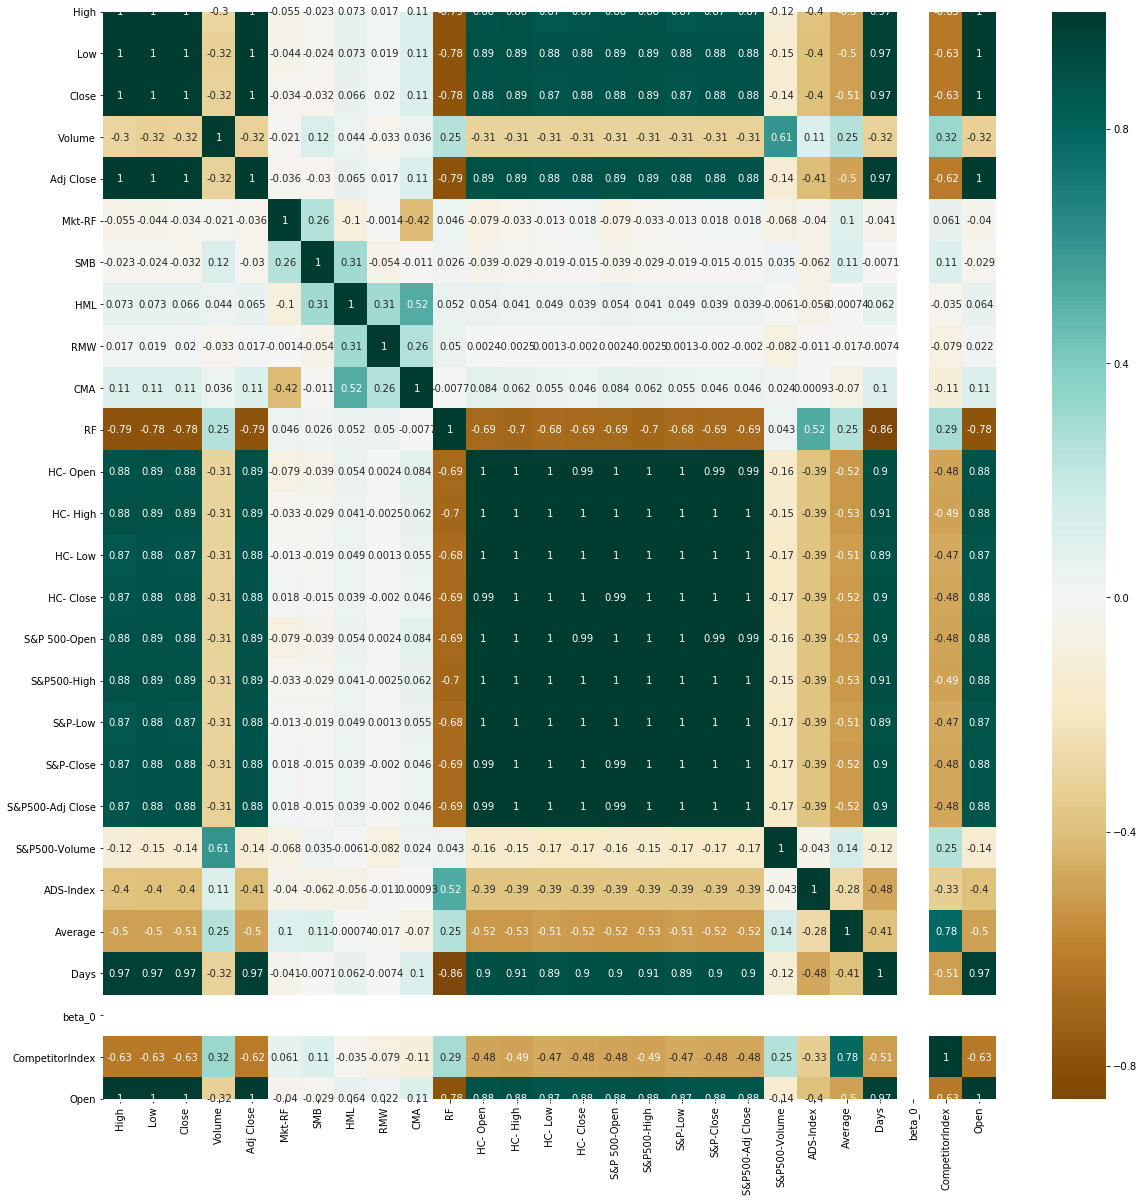

In [26]:
## EDA for identifying independent variables for the model
variable_correlation(modified_df)

In [27]:
train_start_date = "2019-01-01"
train_end_date =  "2019-12-31"
main_train_df = modified_df[(modified_df["Date"] >= train_start_date) & (modified_df["Date"] <= train_end_date)]
main_train_df.head()

,Date,High,Low,Close,Volume,Adj Close,Mkt-RF,SMB,HML,RMW,...,S&P-Low,S&P-Close,S&P500-Adj Close,S&P500-Volume,ADS-Index,Average,Days,beta_0,CompetitorIndex,Open
0,2019-01-02,91.389999,89.930000,91.279999,9843900.0,88.258690,0.23,0.73,1.15,-0.13,...,2467.469971,2510.030029,2510.030029,3.733160e+09,0.154689,53.859375,1.0,1.0,14.249097,90.940002
1,2019-01-03,92.500000,90.379997,90.639999,9820200.0,87.639870,-2.45,0.52,1.23,-0.25,...,2443.959961,2447.889893,2447.889893,3.822860e+09,0.143820,53.531250,2.0,1.0,14.479895,90.839996
2,2019-01-04,92.489998,90.370003,92.489998,10565700.0,89.428635,3.55,0.39,-0.74,-0.09,...,2474.330078,2531.939941,2531.939941,4.213410e+09,0.132721,52.343750,3.0,1.0,13.342649,91.910004
3,2019-01-07,92.500000,91.400002,92.120003,9012500.0,89.070892,0.94,0.82,-0.67,-0.70,...,2524.560059,2549.689941,2549.689941,4.104710e+09,0.121334,53.984375,4.0,1.0,12.847126,92.699997
4,2019-01-08,93.089996,91.820000,92.459999,9551300.0,89.399635,1.01,0.44,-0.53,0.35,...,2547.560059,2574.409912,2574.409912,4.083030e+09,0.109397,57.507812,5.0,1.0,12.525062,92.690002


In [28]:
test_start_date = "2019-12-01"
test_end_date = "2019-12-31"
main_test_df = modified_df[(modified_df["Date"] >= test_start_date) & (modified_df["Date"] <= test_end_date)]
main_test_df.head()

,Date,High,Low,Close,Volume,Adj Close,Mkt-RF,SMB,HML,RMW,...,S&P-Low,S&P-Close,S&P500-Adj Close,S&P500-Volume,ADS-Index,Average,Days,beta_0,CompetitorIndex,Open
231,2019-12-02,122.779999,120.959999,122.720001,6146200.0,121.995201,-0.87,-0.12,0.43,0.15,...,3110.780029,3113.870117,3113.870117,3.268740e+09,-1.105333,37.687500,232.0,1.0,1.599864,122.309998
232,2019-12-03,122.959999,121.800003,122.949997,6396200.0,122.223839,-0.66,0.41,-0.81,-0.50,...,3070.330078,3093.199951,3093.199951,3.653390e+09,-1.089619,37.210938,233.0,1.0,2.222398,122.750000
233,2019-12-04,124.580002,122.690002,124.529999,6857300.0,123.794510,0.60,0.21,0.19,0.17,...,3102.530029,3112.760010,3112.760010,3.695030e+09,-1.071888,37.609375,234.0,1.0,0.895326,124.269997
234,2019-12-05,124.629997,123.660004,124.620003,7029200.0,123.883987,0.13,-0.16,0.51,0.28,...,3103.760010,3117.429932,3117.429932,3.355750e+09,-1.054117,37.570312,235.0,1.0,1.357310,124.730003
235,2019-12-06,125.449997,123.889999,124.190002,7150900.0,123.456520,0.91,0.38,0.43,0.34,...,3134.620117,3145.909912,3145.909912,3.479480e+09,-1.038204,36.664062,236.0,1.0,0.586879,124.309998


In [29]:
y_pred = list()
for i in range(len(main_test_df)):
    colm = colm = ['beta_0','RF', 'RMW',"Volume","SMB","Mkt-RF","HML","CMA","Average","Close","CompetitorIndex"]
    train_df = main_train_df.iloc[i:i+231]
    test_df = main_test_df.iloc[i:i+1]
    y_p = lr(train_df,test_df,colm)
    y_p = y_p.tolist()
    y_pred.append(y_p)

y_pred = pd.DataFrame(y_pred, columns =['Y_PRED'])
y_act = main_test_df[["Open"]].reset_index(drop= True).rename(columns={"Open": "Y_ACT"})
pred_df = pd.concat([y_pred, y_act], axis=1)

R_2 Value:  0.8292204955857989
RMSE Value:  0.38340357586631524
F Value:  2.843741696769342


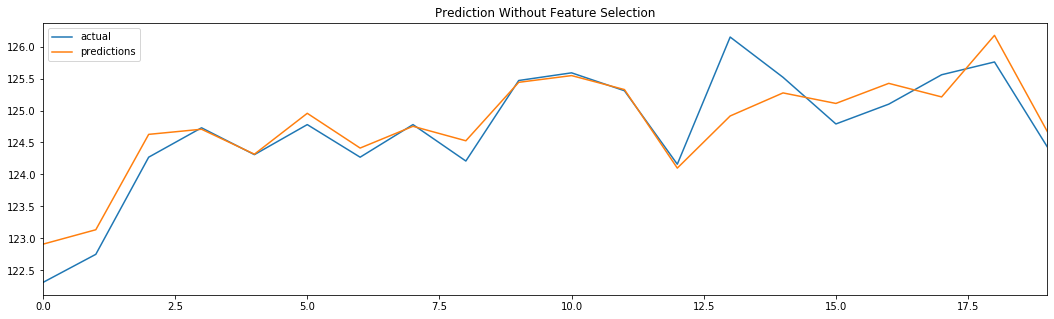

In [30]:
acc = accuracy(pred_df, colm) 
print("R_2 Value: ", acc[0])
print("RMSE Value: ", acc[1] )
print("F Value: ", acc[2])

create_plot(list(pred_df["Y_PRED"]), list(pred_df["Y_ACT"]), title="Prediction Without Feature Selection")

## Feature Selection based on previous model

In [31]:
y_pred = list()
for i in range(len(main_test_df)):
    colm = ["SMB", "CMA","Mkt-RF","Close","CompetitorIndex"]
    train_df = main_train_df.iloc[i:i+231]
    test_df = main_test_df.iloc[i:i+1]
    y_p = lr(train_df,test_df,colm)
    y_p = y_p.tolist()
    y_pred.append(y_p)

y_pred = pd.DataFrame(y_pred, columns =['Y_PRED'])
y_act = main_test_df[["Open"]].reset_index(drop= True).rename(columns={"Open": "Y_ACT"})
pred_df = pd.concat([y_pred, y_act], axis=1)

R_2 Value:  0.8436022519056714
RMSE Value:  0.3669049173951256
F Value:  12.060607319392952


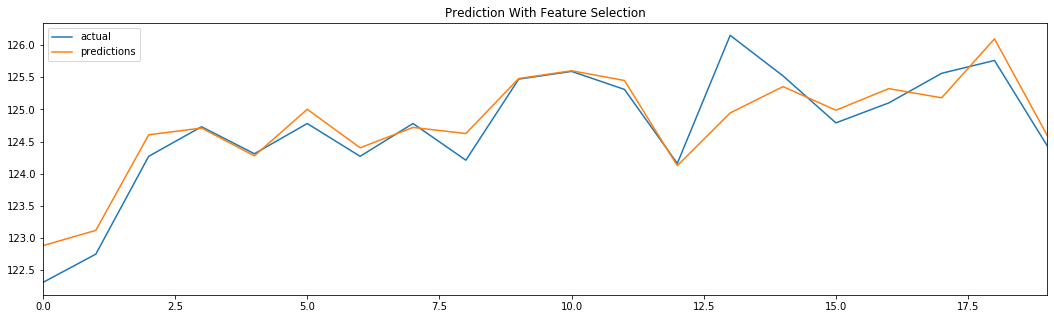

In [32]:
acc = accuracy(pred_df, colm) 
print("R_2 Value: ", acc[0])
print("RMSE Value: ", acc[1] )
print("F Value: ", acc[2])

create_plot(list(pred_df["Y_PRED"]), list(pred_df["Y_ACT"]), title="Prediction With Feature Selection")

## BackTesting Results

In [33]:
back_test_df = backtesting_df(main_test_df, pred_df)
[sharpe_ratio, treynor_ratio, avg_profit, hitrate] = back_test(back_test_df)

print("Backtesting results are given below: ")
print(" 1. Sharpe Ratio is: ", round(sharpe_ratio,2))
print(" 2. Treynor Ratio is: ", round(treynor_ratio,2))
print(" 3. Average Profit is: ", round(avg_profit*100,2), "%")
print(" 4. Hit Rate is: ", round(hitrate,2))

Backtesting results are given below: 
 1. Sharpe Ratio is:  1.16
 2. Treynor Ratio is:  1.84
 3. Average Profit is:  57.64 %
 4. Hit Rate is:  1.0
